In [1]:
%matplotlib notebook

import time
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np
import copy
from astropy.convolution import convolve
from astropy.convolution import Gaussian1DKernel
from scipy.special import erf
from scipy.stats import sigmaclip
from scipy.optimize import minimize
import emcee
import pandas as pd
import warnings
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec 
from scipy.stats import truncnorm
from scipy.stats import skew
from scipy.stats import kurtosis
import tqdm

In [2]:
# ----- Basic parameters ----- #
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
redshift = 0.3527
dist_lum = cosmo.luminosity_distance(redshift).value*1.0e+6    # pc

wav_NII_6548 = 6549.86    # Angstrom (SDSS)
wav_NII_6584 = 6585.27    # Angstrom (SDSS)
wav_Ha = 6564.61    # Angstrom (SDSS)
wav_SII_6717 = 6718.29    # Angstrom (SDSS)
wav_SII_6731 = 6732.67    # Angstrom (SDSS)
wav_OII_3727 = 3727.092    # Angstrom (SDSS)
wav_OII_3729 = 3729.875    # Angstrom (SDSS)
wav_OIII_4959 = 4960.295    # Angstrom (SDSS)
wav_OIII_5007 = 5008.240    # Angstrom (SDSS)
c = 2.99792e+5    # km/s

# ----- Loading Voronoi binned data ----- #
dir_vbin = 'vorbin/'
vb = np.load(dir_vbin+'vorbin_array.npz')
# wav, sci, var
wav_obs = vb['wav']
wav_res = wav_obs / (1.0+redshift)
binned_spectrum = vb['sci']
binned_variance = vb['var']
data_vbin = fits.getdata(dir_vbin+'vbin.fits').astype('int')
nbin = binned_spectrum.shape[1]

In [3]:
print(np.unique(data_vbin, return_counts=True))
binNum, binNpix = np.unique(data_vbin, return_counts=True)
print(0.01*np.sum((binNpix == 1)))
print(0.01*np.sum((binNpix <= 4)))

(array([-99,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166]), array([1755,    1,    1,    1,    1,    1,    1,    1,    1,    1,

In [4]:
# Continuum smoothing & subtraction
binned_spec2 = copy.deepcopy(binned_spectrum)
g1 = Gaussian1DKernel(stddev = 100)
g2 = Gaussian1DKernel(stddev = 4)

wav_msk = np.array([[4850, 4880],  # H beta
                    [4950, 5020],  # [OIII]4959/5007
                    [6530, 6610],  # [NII] + H alpha
                    [6700, 6750]   # [SII]
                   ])
wav_msk = wav_msk*(1.0+redshift)


data0 = np.zeros_like(binned_spectrum)
cont0 = np.zeros_like(binned_spectrum)
for i in np.arange(nbin):
    clipped, lower, upper = sigmaclip(binned_spectrum[:, i], low=3.0, high=3.0)
    smooth_cnd = ((binned_spectrum[:, i] >  lower) & \
                  (binned_spectrum[:, i] <  upper))
    binned_spec2[:, i][~smooth_cnd] = np.nan

    for j in np.arange(wav_msk.shape[0]):
        spx_l = np.abs(wav_obs-wav_msk[j,0]).argmin()
        spx_r = np.abs(wav_obs-wav_msk[j,1]).argmin()
        binned_spec2[spx_l:spx_r+1, i] = np.nan

    f1 = convolve(binned_spec2[:, i], g1)

    binned_spec2[:, i][~smooth_cnd] = f1[~smooth_cnd]
    for j in np.arange(wav_msk.shape[0]):
        spx_l = np.abs(wav_obs-wav_msk[j,0]).argmin()
        spx_r = np.abs(wav_obs-wav_msk[j,1]).argmin()
        binned_spec2[spx_l:spx_r+1, i] = f1[spx_l:spx_r+1]

    f2 = convolve(binned_spec2[:, i], g2)
    binned_spec2[:, i] = binned_spectrum[:, i] - f2

    data0[:, i] = binned_spectrum[:, i]# - f2
    cont0[:, i] = f1

# dat = data0 * (1.0+redshift)
dat = binned_spec2 * (1.0+redshift)
var = binned_variance * (1.0+redshift)**2.0
cont = cont0

# Reading the spectral resolution fitting results
par, e_par = np.loadtxt('relation_wav_R.txt').T

In [5]:
n_integrate = 12
integrated_spectrum = np.sum(dat[:, :n_integrate], axis=1)
integrated_variance = np.sum(var[:, :n_integrate], axis=1)
integrated_continuum = np.sum(cont[:, :n_integrate], axis=1)

<IPython.core.display.Javascript object>


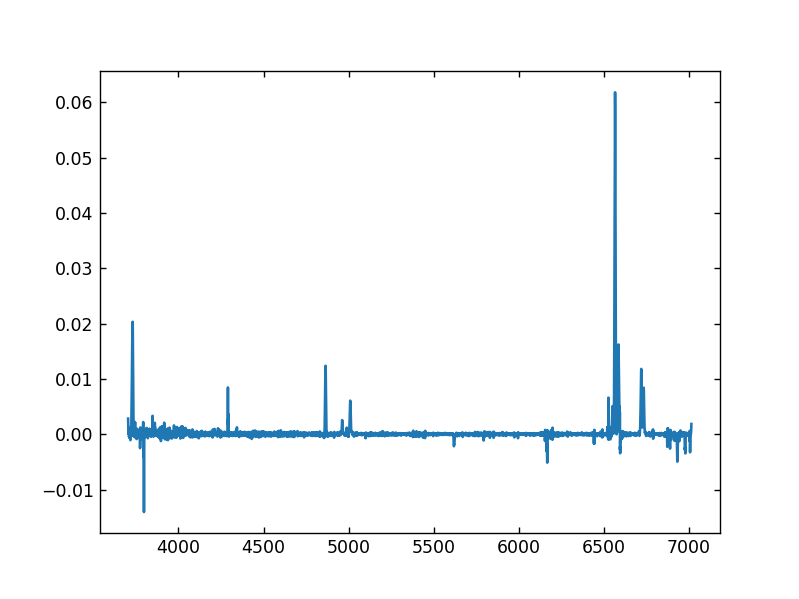

In [6]:
fig, ax = plt.subplots()
ax.plot(wav_res, integrated_spectrum)

In [7]:
from scipy.optimize import curve_fit
from scipy.special import erf

def gauss_cdf_scale(x, mu, sigma, flux_scale):
    dx = x[1] - x[0]
    v1 = erf((x-mu+0.5*dx)/(np.sqrt(2.0)*sigma))
    v2 = erf((x-mu-0.5*dx)/(np.sqrt(2.0)*sigma))
    return flux_scale*(v1-v2)/(2.0*dx)

def multi2_gauss_cdf_scale(x, *pars):
    g1 = gauss_cdf_scale(x, pars[0], pars[1], pars[2])
    g2 = gauss_cdf_scale(x, pars[3], pars[4], pars[5])
    return g1+g2

def multi3_gauss_cdf_scale(x, *pars):
    g1 = gauss_cdf_scale(x, pars[0], pars[1], pars[2])
    g2 = gauss_cdf_scale(x, pars[3], pars[4], pars[5])
    g3 = gauss_cdf_scale(x, pars[6], pars[7], pars[8])
    return g1+g2+g3

In [8]:
def line_par(line_numbers):
    
    if (line_numbers == 1):
        nlines = 1
        line_names = ['Hbeta']
        line_wav = [4862.68]
        wav_fit = [4855.0, 4870.0]
        line_model = gauss_cdf_scale

    if (line_numbers == 2):
        nlines = 2
        line_names = ['OIII4959', 'OIII5007']
        line_wav = [4960.295, 5008.240]
        wav_fit = [4950.0, 5015.0]
        line_model = multi2_gauss_cdf_scale

    if (line_numbers == 3):
        nlines = 3
        line_names = ['NII6548', 'Halpha', 'NII6584']
        line_wav = [6549.86, 6564.61, 6585.27]
        wav_fit = [6545.0, 6590.0]
        line_model = multi3_gauss_cdf_scale

    if (line_numbers == 4):
        nlines = 2
        line_names = ['SII6717', 'SII6731']
        line_wav = [6718.29, 6732.67]
        wav_fit = [6710.0, 6740.0]
        line_model = multi2_gauss_cdf_scale
    
    return [nlines, line_names, line_wav, wav_fit, line_model]

f = open('linefit_integrated.txt','w')
f.write('# line  mu  e_mu  lsig  e_lsig  vsig  e_vsig  R  e_R  flux  e_flux  rchisq\n')
f.close()

100%|██████████| 1000/1000 [00:08<00:00, 123.13it/s]

NII6548 mean: 6551.928 +/- 0.116 Angstrom
NII6548 sigma: 2.438 +/- 0.104 Angstrom
NII6548 sigma: 111.54 +/- 4.744 km/s
NII6548 R: 1229.63 +/- 91.01
NII6548 flux: 3.07e-02 +/- 1.24e-03
NII6548 reduced chi-square: 1.66


Halpha mean: 6566.743 +/- 0.014 Angstrom
Halpha sigma: 2.637 +/- 0.012 Angstrom
Halpha sigma: 120.39 +/- 0.565 km/s
Halpha R: 1232.85 +/- 91.13
Halpha flux: 4.08e-01 +/- 1.87e-03
Halpha reduced chi-square: 2.68


NII6584 mean: 6587.408 +/- 0.054 Angstrom
NII6584 sigma: 2.600 +/- 0.067 Angstrom
NII6584 sigma: 118.33 +/- 3.050 km/s
NII6584 R: 1237.36 +/- 91.28
NII6584 flux: 1.01e-01 +/- 2.07e-03
NII6584 reduced chi-square: 1.70




<IPython.core.display.Javascript object>


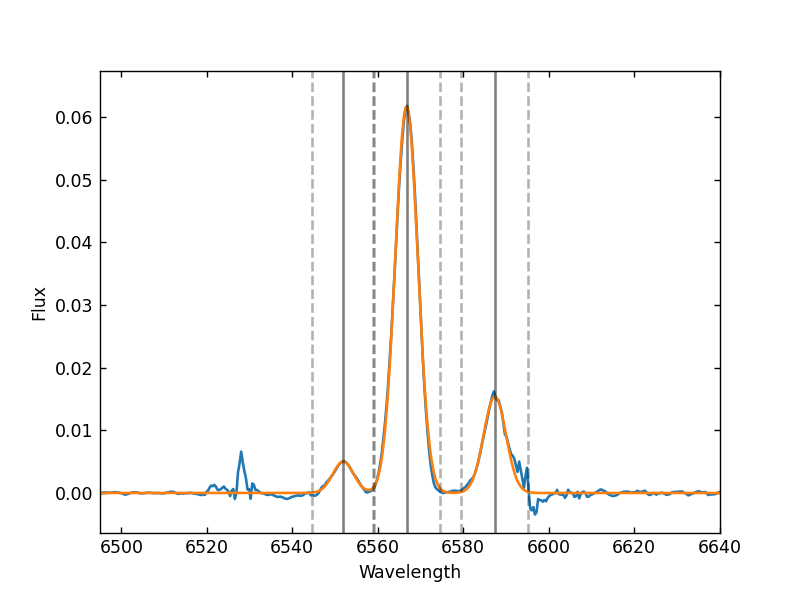

In [9]:
# Line fitting: Monte Carlo simulation of curve_fit (H alpha)
line_numbers = 3

nlines, line_names, line_wav, wav_fit, line_model = line_par(line_numbers)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_fit = wav_res[spx_fit[0]:spx_fit[1]+1]

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_var = integrated_variance[spx_fit[0]:spx_fit[1]+1]
    y_dat = np.random.normal(integrated_spectrum[spx_fit[0]:spx_fit[1]+1], np.sqrt(y_var))
    y_fit = y_dat
    flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
    
    param = []
    for j in np.arange(nlines):
        param += [line_wav[j], 3.0, flx_scale0]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)

# Printing the results
f = open('linefit_integrated.txt','a')
for i in np.arange(nlines):
    
    print(line_names[i]+f" mean: {mpar[3*i]:.3f} +/- {e_mpar[3*i]:.3f} Angstrom")
    f.write(line_names[i]+f"  {mpar[3*i]:.3f}  {e_mpar[3*i]:.3f}  ")
    
    print(line_names[i]+f" sigma: {mpar[3*i+1]:.3f} +/- {e_mpar[3*i+1]:.3f} Angstrom")
    f.write(f"{mpar[3*i+1]:.3f}  {e_mpar[3*i+1]:.3f}  ")
    vsig = c*mpar[3*i+1] / mpar[3*i]
    e_vsig = vsig*np.sqrt((e_mpar[3*i]/mpar[3*i])**2.0 + (e_mpar[3*i+1]/mpar[3*i+1])**2.0)
    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
    
    specR = par[0]+par[1]*mpar[3*i]*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mpar[3*i]*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")
    f.write(f"{specR:.2f}  {e_specR:.2f}  ")
    
    print(line_names[i]+f" flux: {mpar[3*i+2]:.2e} +/- {e_mpar[3*i+2]:.2e}")
    f.write(f"{mpar[3*i+2]:.2e}  {e_mpar[3*i+2]:.2e}  ")
    
    spx_line = [np.abs(x_fit-(mpar[3*i]-3*mpar[3*i+1])).argmin(),
                np.abs(x_fit-(mpar[3*i]+3*mpar[3*i+1])).argmin()]
    chisq = ((y_fit-line_model(x_fit, *mpar))/np.sqrt(y_var))**2.
    dof = len(y_fit[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
#     rchisq = np.sum(((y_fit-line_model(x_fit, *mpar))/np.sqrt(y_var))**2.) / (len(y_fit)-3*nlines)
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    f.write(f"{rchisq:.2f}\n")
    print("\n")
    
f.close()
    
# Figure
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_dat)-5.0e-3, np.max(y_dat)+5.0e-3])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, integrated_spectrum)
ax.plot(wav_res, line_model(wav_res, *mpar))
for i in np.arange(nlines):
    ax.axvline(mpar[3*i], color='k', linestyle='-', alpha=0.5)
    ax.axvline(mpar[3*i]-3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)
    ax.axvline(mpar[3*i]+3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)

100%|██████████| 1000/1000 [00:01<00:00, 809.97it/s]

Hbeta mean: 4864.355 +/- 0.056 Angstrom
Hbeta sigma: 2.320 +/- 0.051 Angstrom
Hbeta sigma: 143.00 +/- 3.140 km/s
Hbeta R: 861.87 +/- 79.04
Hbeta flux: 7.30e-02 +/- 1.45e-03
Hbeta reduced chi-square: 1.21




<IPython.core.display.Javascript object>


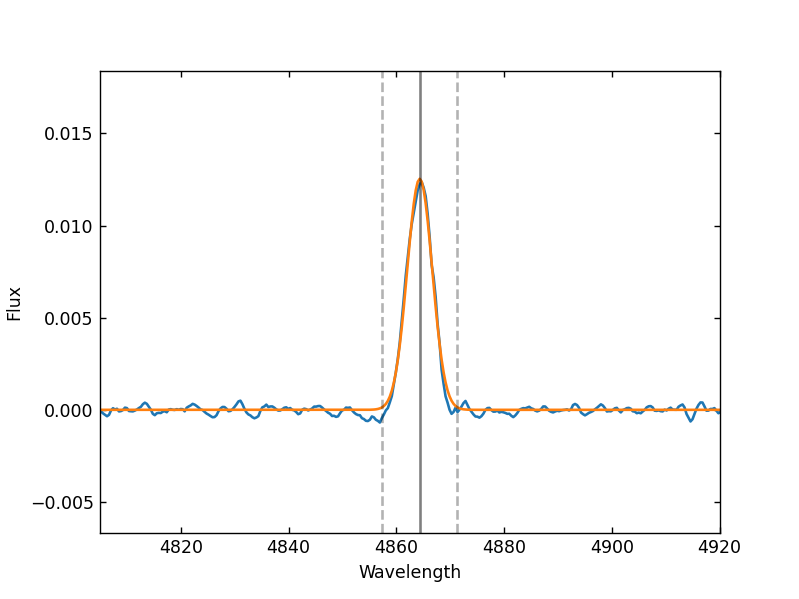

In [10]:
# Line fitting: Monte Carlo simulation of curve_fit (H beta)
line_numbers = 1

nlines, line_names, line_wav, wav_fit, line_model = line_par(line_numbers)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_fit = wav_res[spx_fit[0]:spx_fit[1]+1]

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_var = integrated_variance[spx_fit[0]:spx_fit[1]+1]
    y_dat = np.random.normal(integrated_spectrum[spx_fit[0]:spx_fit[1]+1], np.sqrt(y_var))
    y_fit = y_dat
    flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
    
    param = []
    for j in np.arange(nlines):
        param += [line_wav[j], 3.0, flx_scale0]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)

# Printing the results
f = open('linefit_integrated.txt','a')
for i in np.arange(nlines):
    
    print(line_names[i]+f" mean: {mpar[3*i]:.3f} +/- {e_mpar[3*i]:.3f} Angstrom")
    f.write(line_names[i]+f"  {mpar[3*i]:.3f}  {e_mpar[3*i]:.3f}  ")
    
    print(line_names[i]+f" sigma: {mpar[3*i+1]:.3f} +/- {e_mpar[3*i+1]:.3f} Angstrom")
    f.write(f"{mpar[3*i+1]:.3f}  {e_mpar[3*i+1]:.3f}  ")
    vsig = c*mpar[3*i+1] / mpar[3*i]
    e_vsig = vsig*np.sqrt((e_mpar[3*i]/mpar[3*i])**2.0 + (e_mpar[3*i+1]/mpar[3*i+1])**2.0)
    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
    
    specR = par[0]+par[1]*mpar[3*i]*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mpar[3*i]*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")
    f.write(f"{specR:.2f}  {e_specR:.2f}  ")
    
    print(line_names[i]+f" flux: {mpar[3*i+2]:.2e} +/- {e_mpar[3*i+2]:.2e}")
    f.write(f"{mpar[3*i+2]:.2e}  {e_mpar[3*i+2]:.2e}  ")
    
    spx_line = [np.abs(x_fit-(mpar[3*i]-3*mpar[3*i+1])).argmin(),
                np.abs(x_fit-(mpar[3*i]+3*mpar[3*i+1])).argmin()]
    chisq = ((y_fit-line_model(x_fit, *mpar))/np.sqrt(y_var))**2.
    dof = len(y_fit[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
#     rchisq = np.sum(((y_fit-line_model(x_fit, *mpar))/np.sqrt(y_var))**2.) / (len(y_fit)-3*nlines)
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    f.write(f"{rchisq:.2f}\n")
    print("\n")
    
f.close()
    
# Figure
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_dat)-5.0e-3, np.max(y_dat)+5.0e-3])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, integrated_spectrum)
ax.plot(wav_res, line_model(wav_res, *mpar))
for i in np.arange(nlines):
    ax.axvline(mpar[3*i], color='k', linestyle='-', alpha=0.5)
    ax.axvline(mpar[3*i]-3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)
    ax.axvline(mpar[3*i]+3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)

100%|██████████| 1000/1000 [00:05<00:00, 179.10it/s]

OIII4959 mean: 4962.291 +/- 0.251 Angstrom
OIII4959 sigma: 2.109 +/- 0.322 Angstrom
OIII4959 sigma: 127.43 +/- 19.424 km/s
OIII4959 R: 883.21 +/- 79.68
OIII4959 flux: 1.27e-02 +/- 1.37e-03
OIII4959 reduced chi-square: 0.82


OIII5007 mean: 5009.848 +/- 0.107 Angstrom
OIII5007 sigma: 2.706 +/- 0.114 Angstrom
OIII5007 sigma: 161.96 +/- 6.850 km/s
OIII5007 R: 893.58 +/- 80.00
OIII5007 flux: 4.16e-02 +/- 1.45e-03
OIII5007 reduced chi-square: 1.36




<IPython.core.display.Javascript object>


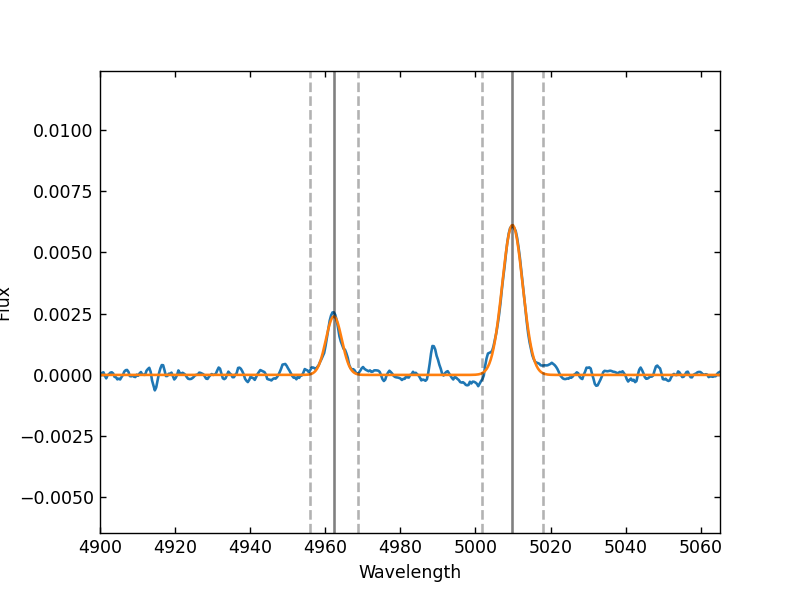

In [11]:
# Line fitting: Monte Carlo simulation of curve_fit ([OIII]4959/5007)
line_numbers = 2

nlines, line_names, line_wav, wav_fit, line_model = line_par(line_numbers)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_fit = wav_res[spx_fit[0]:spx_fit[1]+1]

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_var = integrated_variance[spx_fit[0]:spx_fit[1]+1]
    y_dat = np.random.normal(integrated_spectrum[spx_fit[0]:spx_fit[1]+1], np.sqrt(y_var))
    y_fit = y_dat
    flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
    
    param = []
    for j in np.arange(nlines):
        param += [line_wav[j], 3.0, flx_scale0]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)

# Printing the results
f = open('linefit_integrated.txt','a')
for i in np.arange(nlines):
    
    print(line_names[i]+f" mean: {mpar[3*i]:.3f} +/- {e_mpar[3*i]:.3f} Angstrom")
    f.write(line_names[i]+f"  {mpar[3*i]:.3f}  {e_mpar[3*i]:.3f}  ")
    
    print(line_names[i]+f" sigma: {mpar[3*i+1]:.3f} +/- {e_mpar[3*i+1]:.3f} Angstrom")
    f.write(f"{mpar[3*i+1]:.3f}  {e_mpar[3*i+1]:.3f}  ")
    vsig = c*mpar[3*i+1] / mpar[3*i]
    e_vsig = vsig*np.sqrt((e_mpar[3*i]/mpar[3*i])**2.0 + (e_mpar[3*i+1]/mpar[3*i+1])**2.0)
    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
    
    specR = par[0]+par[1]*mpar[3*i]*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mpar[3*i]*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")
    f.write(f"{specR:.2f}  {e_specR:.2f}  ")
    
    print(line_names[i]+f" flux: {mpar[3*i+2]:.2e} +/- {e_mpar[3*i+2]:.2e}")
    f.write(f"{mpar[3*i+2]:.2e}  {e_mpar[3*i+2]:.2e}  ")
    
    spx_line = [np.abs(x_fit-(mpar[3*i]-3*mpar[3*i+1])).argmin(),
                np.abs(x_fit-(mpar[3*i]+3*mpar[3*i+1])).argmin()]
    chisq = ((y_fit-line_model(x_fit, *mpar))/np.sqrt(y_var))**2.
    dof = len(y_fit[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
#     rchisq = np.sum(((y_fit-line_model(x_fit, *mpar))/np.sqrt(y_var))**2.) / (len(y_fit)-3*nlines)
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    f.write(f"{rchisq:.2f}\n")
    print("\n")
    
f.close()
    
# Figure
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_dat)-5.0e-3, np.max(y_dat)+5.0e-3])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, integrated_spectrum)
ax.plot(wav_res, line_model(wav_res, *mpar))
for i in np.arange(nlines):
    ax.axvline(mpar[3*i], color='k', linestyle='-', alpha=0.5)
    ax.axvline(mpar[3*i]-3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)
    ax.axvline(mpar[3*i]+3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)

100%|██████████| 1000/1000 [00:03<00:00, 308.21it/s]

SII6717 mean: 6720.647 +/- 0.047 Angstrom
SII6717 sigma: 2.753 +/- 0.051 Angstrom
SII6717 sigma: 122.82 +/- 2.284 km/s
SII6717 R: 1266.39 +/- 92.31
SII6717 flux: 8.00e-02 +/- 1.23e-03
SII6717 reduced chi-square: 1.95


SII6731 mean: 6734.841 +/- 0.067 Angstrom
SII6731 sigma: 2.858 +/- 0.078 Angstrom
SII6731 sigma: 127.22 +/- 3.451 km/s
SII6731 R: 1269.49 +/- 92.41
SII6731 flux: 5.96e-02 +/- 1.24e-03
SII6731 reduced chi-square: 1.45




<IPython.core.display.Javascript object>


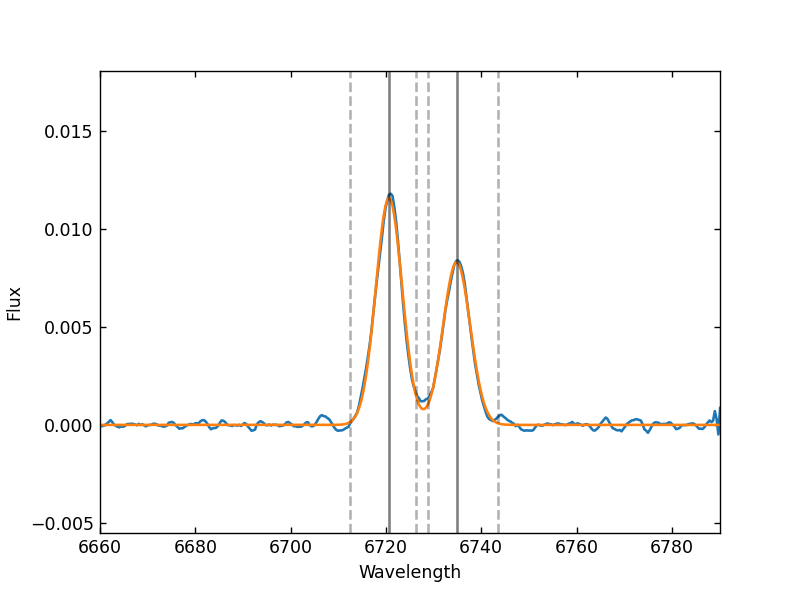

In [12]:
# Line fitting: Monte Carlo simulation of curve_fit ([SII]6717,6731)
line_numbers = 4

nlines, line_names, line_wav, wav_fit, line_model = line_par(line_numbers)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_fit = wav_res[spx_fit[0]:spx_fit[1]+1]

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_var = integrated_variance[spx_fit[0]:spx_fit[1]+1]
    y_dat = np.random.normal(integrated_spectrum[spx_fit[0]:spx_fit[1]+1], np.sqrt(y_var))
    y_fit = y_dat
    flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
    
    param = []
    for j in np.arange(nlines):
        param += [line_wav[j], 3.0, flx_scale0]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)

# Printing the results
f = open('linefit_integrated.txt','a')
for i in np.arange(nlines):
    
    print(line_names[i]+f" mean: {mpar[3*i]:.3f} +/- {e_mpar[3*i]:.3f} Angstrom")
    f.write(line_names[i]+f"  {mpar[3*i]:.3f}  {e_mpar[3*i]:.3f}  ")
    
    print(line_names[i]+f" sigma: {mpar[3*i+1]:.3f} +/- {e_mpar[3*i+1]:.3f} Angstrom")
    f.write(f"{mpar[3*i+1]:.3f}  {e_mpar[3*i+1]:.3f}  ")
    vsig = c*mpar[3*i+1] / mpar[3*i]
    e_vsig = vsig*np.sqrt((e_mpar[3*i]/mpar[3*i])**2.0 + (e_mpar[3*i+1]/mpar[3*i+1])**2.0)
    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
    
    specR = par[0]+par[1]*mpar[3*i]*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mpar[3*i]*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")
    f.write(f"{specR:.2f}  {e_specR:.2f}  ")
    
    print(line_names[i]+f" flux: {mpar[3*i+2]:.2e} +/- {e_mpar[3*i+2]:.2e}")
    f.write(f"{mpar[3*i+2]:.2e}  {e_mpar[3*i+2]:.2e}  ")
    
    spx_line = [np.abs(x_fit-(mpar[3*i]-3*mpar[3*i+1])).argmin(),
                np.abs(x_fit-(mpar[3*i]+3*mpar[3*i+1])).argmin()]
    chisq = ((y_fit-line_model(x_fit, *mpar))/np.sqrt(y_var))**2.
    dof = len(y_fit[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
#     rchisq = np.sum(((y_fit-line_model(x_fit, *mpar))/np.sqrt(y_var))**2.) / (len(y_fit)-3*nlines)
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    f.write(f"{rchisq:.2f}\n")
    print("\n")
    
f.close()
    
# Figure
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_dat)-5.0e-3, np.max(y_dat)+5.0e-3])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, integrated_spectrum)
ax.plot(wav_res, line_model(wav_res, *mpar))
for i in np.arange(nlines):
    ax.axvline(mpar[3*i], color='k', linestyle='-', alpha=0.5)
    ax.axvline(mpar[3*i]-3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)
    ax.axvline(mpar[3*i]+3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)